In [31]:
import json
import os
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"
from pathlib import Path
import pprint
import matplotlib.pyplot as plt
from dataclasses import asdict
import numpy as np
import wandb
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import jax
import jax.numpy as jnp
# sns.set()
import orbax.checkpoint

from meta_transformer.data import load_batches
from meta_transformer import utils, preprocessing, output_dir
from meta_transformer.meta_model import MetaModelClassifier
from backdoors import paths


figdir = "../../writeups/iclr-2023/figures/"

### Detecting backdoors

In [12]:
# - plot ROC curve for each poison type
# - plot ROC curves for OOD test sets
# - compare AUROC to baseline (meta neural analysis and universal litmus patterns)

In [62]:
NUM_SAMPLES = 50
POISON_TYPE = "random_border_pos_pattern"
chunk_size = 128

clean = load_batches(
    paths.TEST_CLEAN / "clean_0", max_datapoints=NUM_SAMPLES)
backdoored = load_batches(
    paths.TEST_BACKDOOR / POISON_TYPE, max_datapoints=NUM_SAMPLES)
clean = utils.tree_stack([x["params"] for x in clean])
backdoored = utils.tree_stack([x["params"] for x in backdoored])


def normalize(x):
    return (x + 0.242) / 3.14


@jax.jit
def process_base_models(params):
    flat = preprocessing.chunk(params, chunk_size)[0]
    return normalize(flat)


clean = jax.vmap(process_base_models)(clean)
backdoored = jax.vmap(process_base_models)(backdoored)


In [63]:
checkpoint_dir = output_dir + "/hpc-mm-checkpoints"
checkpointer = orbax.checkpoint.Checkpointer(orbax.checkpoint.PyTreeCheckpointHandler())
pth = checkpoint_dir + "/random_border_pos_pattern/run_1695834256"

params = checkpointer.restore(pth)
with open(checkpoint_dir + "/random_border_pos_pattern/info.json") as f:
        info = json.load(f)

assert info["chunk_size"] == chunk_size
model_config = info["model_config"]
model = MetaModelClassifier(**model_config)

In [99]:
logits_on_clean, _ = model.apply({"params": params}, clean)
logits_on_backdoored, _ = model.apply({"params": params}, backdoored)
print("clean logits range:", logits_on_clean.min(), logits_on_clean.max())
print("backdoored logits range:", logits_on_backdoored.min(), logits_on_backdoored.max())

thresholds = np.arange(-10, 15, 0.05)
fpr = {}
tpr = {}
for t in thresholds:
    fpr[t] = np.mean((logits_on_clean > t) == 1)
    tpr[t] = np.mean((logits_on_backdoored > t) == 1)

clean logits range: -9.545995 0.8833482
backdoored logits range: -2.2558486 11.697161


/tmp/ipykernel_129647/3726526185.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([""])


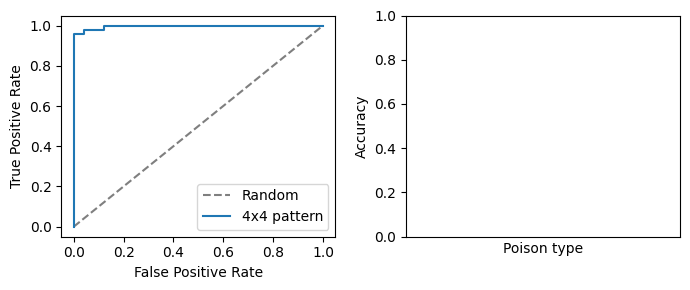

In [100]:
fig, axs = plt.subplots(1, 2, figsize=(7, 3))

ax = axs[0]
ax.plot([0, 1], [0, 1], '--', label="Random", color="tab:grey")
ax.plot(fpr.values(), tpr.values(), label="4x4 pattern", color="tab:blue")

ax.set_xlabel("False Positive Rate")
ax.set_ylabel("True Positive Rate")
#ax.set_ylim((-0.01, 1.01))
#ax.set_xlim((-0.01, 1.01))
ax.legend()

ax = axs[1]
ax.plot()
ax.set_ylabel("Accuracy")
ax.set_xlabel("Poison type")
ax.set_ylim((0, 1))
ax.set_xticklabels([""])
ax.set_xticks([])

plt.tight_layout()
plt.savefig(figdir + "backdoors_roc.pdf", bbox_inches="tight")

### Comparison to CTC

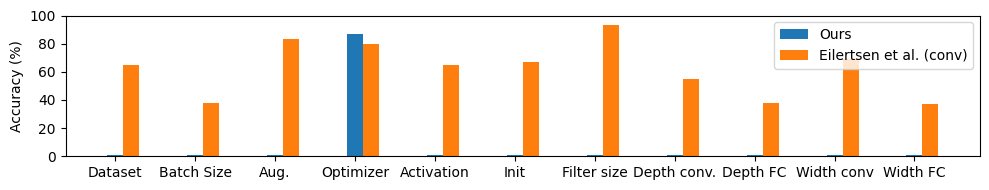

In [11]:
# first, remake ctc bar chart by copying their results by hand. then, next to every bar put our own results

ctc_conv_results = {
    "Dataset": 65,
    "Batch Size": 38,
    "Aug.": 83,
    "Optimizer": 79.5,
    "Activation": 65,
    "Init": 67,
    "Filter size": 93,
    "Depth conv.": 55,
    "Depth FC": 38,
    "Width conv": 69,
    "Width FC": 37,
}


our_results = {
    "Dataset": 1,
    "Batch Size": 1,
    "Aug.": 1,
    "Optimizer": 87,
    "Activation": 1,
    "Init": 1,
    "Filter size": 1,
    "Depth conv.": 1,
    "Depth FC": 1,
    "Width conv": 1,
    "Width FC": 1,
}

plt.figure(figsize=(10, 2.))
group_positions = np.arange(len(ctc_conv_results.keys()))
group_labels = ctc_conv_results.keys()


bar_width = 0.2
ax = plt.gca()
ax.bar(group_positions, our_results.values(), width=bar_width, label="Ours")
ax.bar(group_positions+bar_width, ctc_conv_results.values(), width=bar_width, label="Eilertsen et al. (conv)")
ax.set_xticks(group_positions)
ax.set_xticklabels(group_labels)
ax.set_ylabel("Accuracy (%)")
ax.set_ylim(0, 100)
ax.legend()

plt.tight_layout()

figpath = "../../writeups/iclr-2023/figures/ctc-comparison.pdf"
plt.savefig(figpath, bbox_inches="tight")